## BLEU functions

In [102]:
import sys
import codecs
import os
import math
import operator
import json
from functools import reduce


def fetch_data(cand, ref):
    """ Store each reference and candidate sentences as a list """
    references = []
    if '.txt' in ref:
        reference_file = codecs.open(ref, 'r')
        references.append(reference_file.readlines())
    else:
        for root, dirs, files in os.walk(ref):
            for f in files:
                reference_file = codecs.open(os.path.join(root, f), 'r')
                references.append(reference_file.readlines())
    candidate_file = codecs.open(cand, 'r')
    candidate = candidate_file.readlines()
    return candidate, references


def count_ngram(candidate, references, n):
    clipped_count = 0
    count = 0
    r = 0
    c = 0
    for si in range(len(candidate)):
        # Calculate precision for each sentence
        ref_counts = []
        ref_lengths = []
        # Build dictionary of ngram counts
        for reference in references:
            ref_sentence = reference[si]
            ngram_d = {}
            words = ref_sentence.strip().split()
            ref_lengths.append(len(words))
            limits = len(words) - n + 1
            # loop through the sentance consider the ngram length
            for i in range(limits):
                ngram = ' '.join(words[i:i+n]).lower()
                if ngram in ngram_d.keys():
                    ngram_d[ngram] += 1
                else:
                    ngram_d[ngram] = 1
            ref_counts.append(ngram_d)
        # candidate
        cand_sentence = candidate[si]
        cand_dict = {}
        words = cand_sentence.strip().split()
        limits = len(words) - n + 1
        for i in range(0, limits):
            ngram = ' '.join(words[i:i + n]).lower()
            if ngram in cand_dict:
                cand_dict[ngram] += 1
            else:
                cand_dict[ngram] = 1
        clipped_count += clip_count(cand_dict, ref_counts)
        count += limits
        r += best_length_match(ref_lengths, len(words))
        c += len(words)
    if clipped_count == 0:
        pr = 0
    else:
        pr = float(clipped_count) / count
    bp = brevity_penalty(c, r)
    return pr, bp


def clip_count(cand_d, ref_ds):
    """Count the clip count for each ngram considering all references"""
    count = 0
    for m in cand_d.keys():
        m_w = cand_d[m]
        m_max = 0
        for ref in ref_ds:
            if m in ref:
                m_max = max(m_max, ref[m])
        m_w = min(m_w, m_max)
        count += m_w
    return count


def best_length_match(ref_l, cand_l):
    """Find the closest length of reference to that of candidate"""
    
    least_diff = abs(cand_l-ref_l[0])
    best = ref_l[0]
    for ref in ref_l:
        if abs(cand_l-ref) < least_diff:
            least_diff = abs(cand_l-ref)
            best = ref
    return best


def brevity_penalty(c, r):
    if c > r:
        bp = 1
    else:
        bp = math.exp(1-(float(r)/c))
    return bp


def geometric_mean(precisions):
    return (reduce(operator.mul, precisions)) ** (1.0 / len(precisions))


def BLEU(candidate, references, n_grams=4):
    precisions = []
    for i in range(n_grams):
        pr, bp = count_ngram(candidate, references, i+1)
        precisions.append(pr)
    bleu = geometric_mean(precisions) * bp    
    return bleu, precisions, bp

## BLEU evaluation

In [105]:
import pandas as pd
ngrams_results = pd.DataFrame()

In [106]:
candidate_file = 'data/translation.txt'
reference_file = 'data/reference.txt'
candidate, references = fetch_data(candidate_file, reference_file)
bleu, partial_scores, bp = BLEU(candidate, references, n_grams=4)
ngrams_results['BLEU'] = partial_scores
print(bleu)

0.19596543504006067


In [107]:
bleu, partial_scores, bp = BLEU(candidate, references, n_grams=3)
print(bleu)

0.2747812332409043


In [112]:
bleu, partial_scores, bp = BLEU(candidate, references, n_grams=5)
print(bleu)

0.13979605471333215


In [48]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [49]:
ngrams_results.index = list(range(1,5))
ngrams_results

,BLEU
1,0.561261
2,0.269809
3,0.137006
4,0.071082


In [62]:
references[0][0]

'tom bumped into mary on his way to school .\n'

In [63]:
candidate[0]

'tom up mary the the the school .\n'

In [73]:
BLEU([candidate[0]], [[references[0][0]]])

(0.0, [0.5, 0.14285714285714285, 0, 0], 0.7788007830714049)

In [53]:
len(candidate)

5688

In [75]:
results = pd.DataFrame(columns=['BLEU', '1-gram', '2-gram', '3-gram', '4-gram', 'Brevity Penalty'])
for i in range(len(candidate)):
    result = BLEU([candidate[i]], [[references[0][i]]])
    results.loc[len(results)] = [result[0], result[1][0], result[1][1], result[1][2], result[1][3], result[2]]

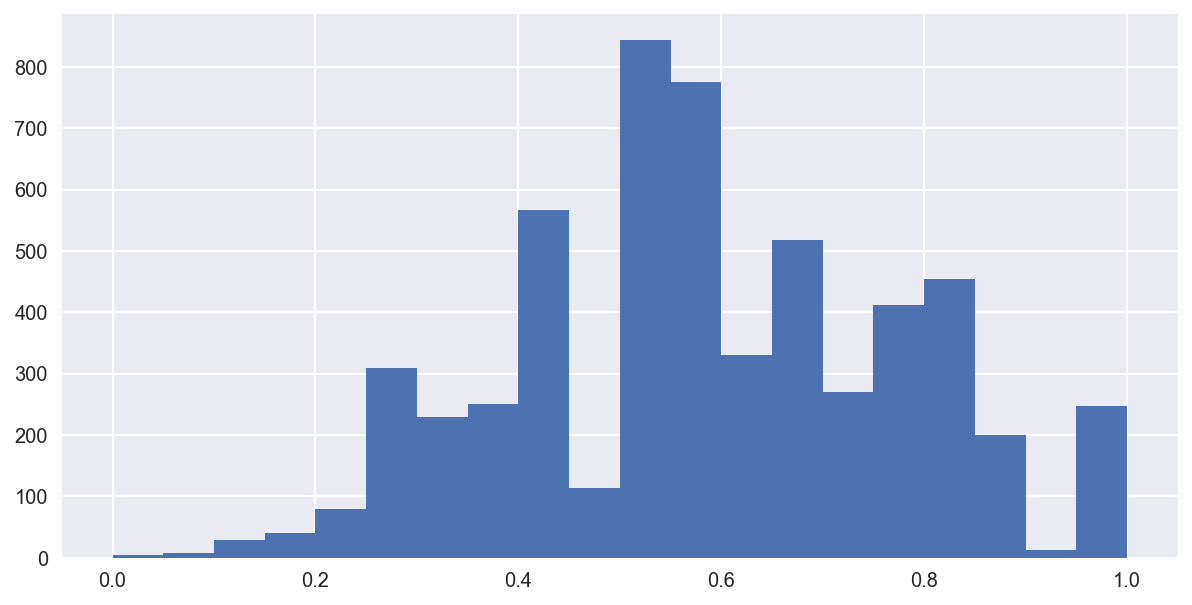

In [84]:
results['1-gram'].hist(bins=20, figsize=(10,5))

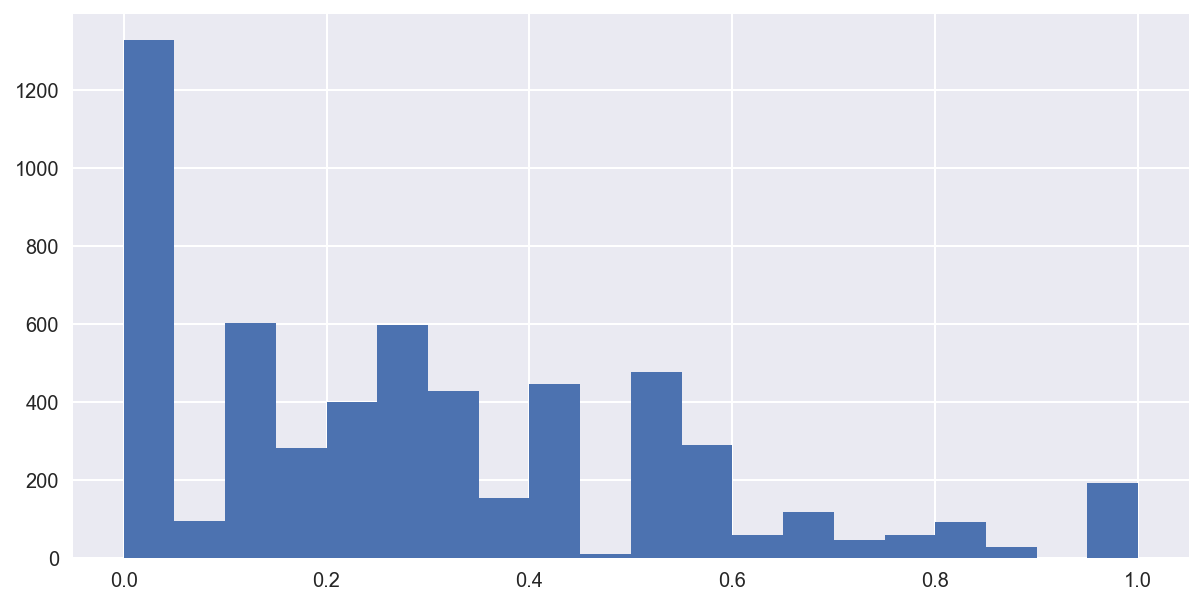

In [85]:
results['2-gram'].hist(bins=20, figsize=(10,5))

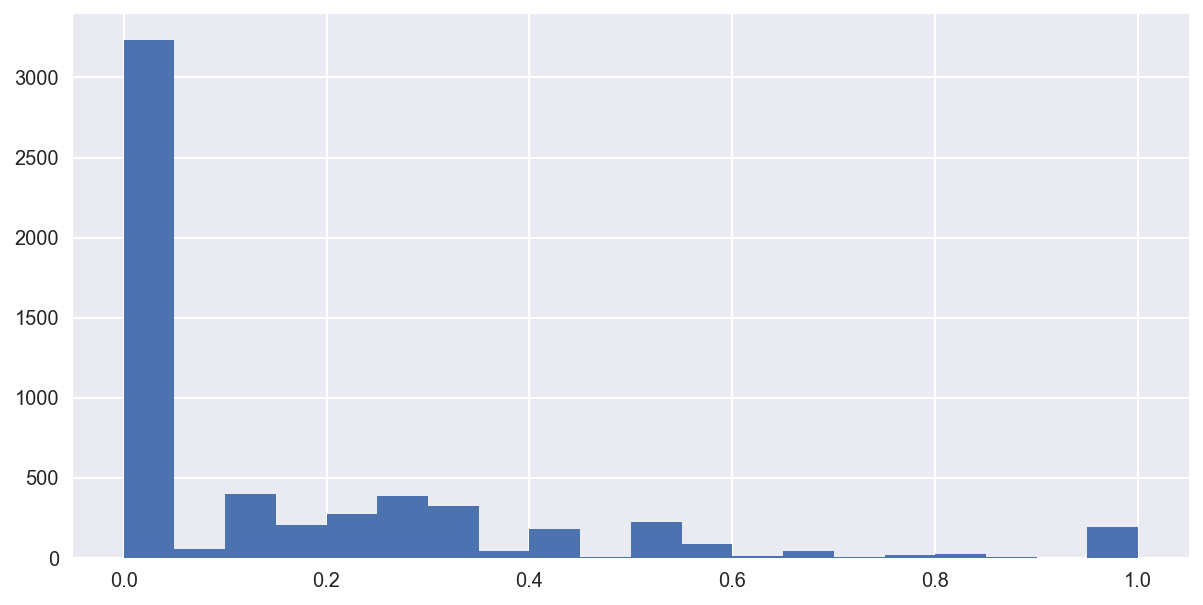

In [86]:
results['3-gram'].hist(bins=20, figsize=(10,5))

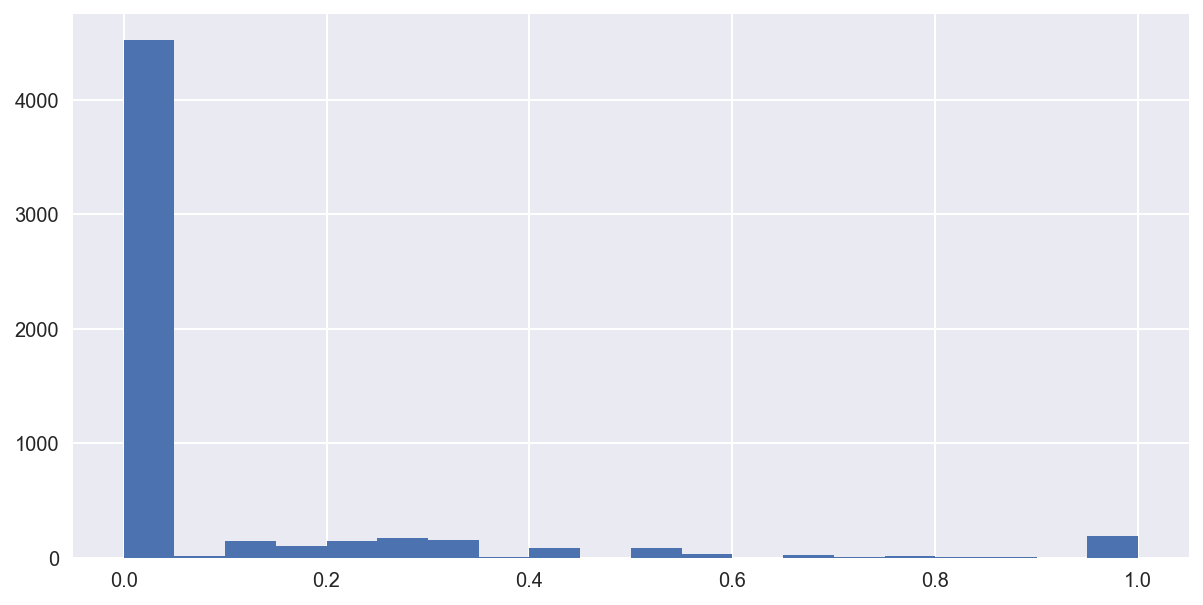

In [87]:
results['4-gram'].hist(bins=20, figsize=(10,5))

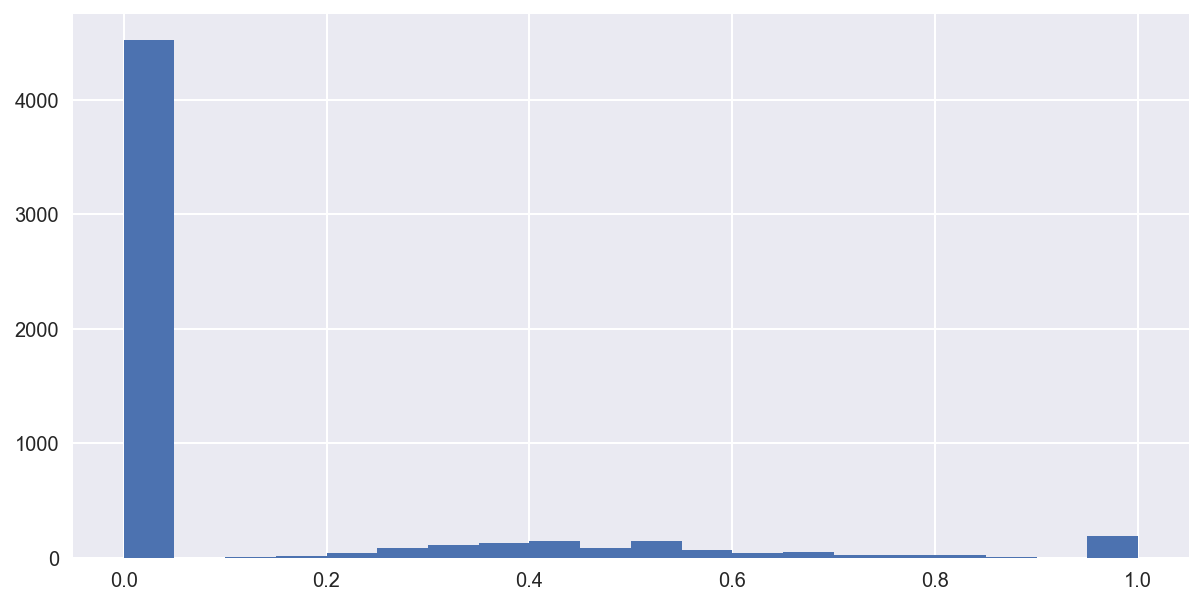

In [88]:
results['BLEU'].hist(bins=20, figsize=(10,5))

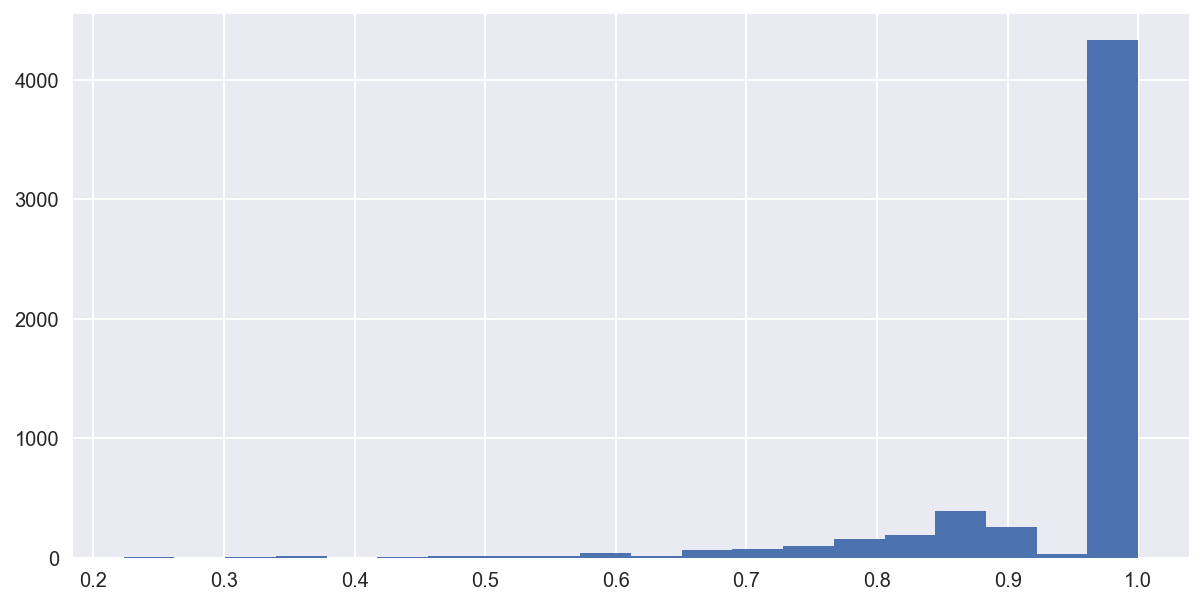

In [89]:
results['Brevity Penalty'].hist(bins=20, figsize=(10,5))

In [91]:
results['Reference'] = references[0]
results['Candidate'] = candidate

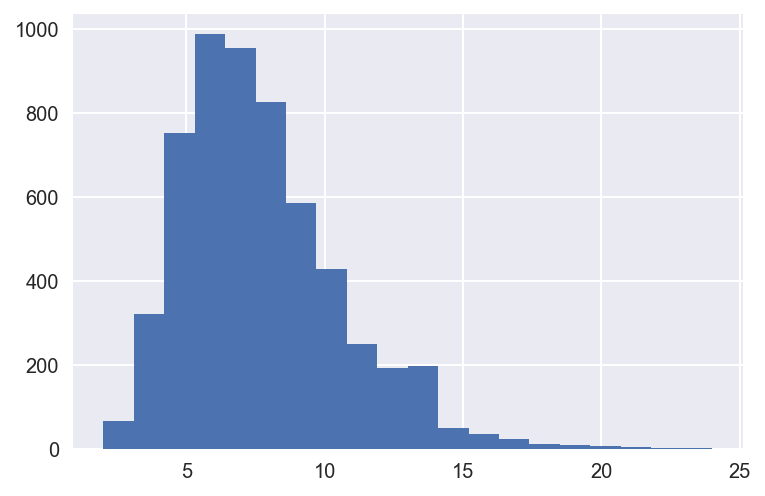

In [114]:
results['Reference'].apply(lambda x: len(x.split())).hist(bins=20)

In [92]:
results

,BLEU,1-gram,2-gram,3-gram,4-gram,Brevity Penalty,Reference,Candidate
0,0.000000,0.500000,0.142857,0.000000,0.000000,0.778801,tom bumped into mary on his way to school .\n,tom up mary the the the school .\n
1,0.000000,0.666667,0.400000,0.000000,0.000000,1.000000,i 'll pay for it .\n,i 'll give it . .\n
2,0.000000,0.571429,0.166667,0.000000,0.000000,1.000000,what happened to the goats ?\n,what happened you the the ? ?\n
3,0.000000,0.538462,0.166667,0.090909,0.000000,0.735141,tom and mary gave exactly the same answers on ...,tom and mary know the the the the the the the ...
4,0.000000,0.636364,0.200000,0.111111,0.000000,1.000000,"tom , i want you to stay with the kids .\n",tom and i want you stay at the . . .\n
5,0.541082,0.750000,0.571429,0.500000,0.400000,1.000000,let tom know where i am .\n,let tom know where i 'm . .\n
6,0.000000,0.600000,0.000000,0.000000,0.000000,1.000000,water the plants .\n,water apples the . .\n
7,0.000000,0.714286,0.500000,0.200000,0.000000,1.000000,tom does n't look too happy .\n,tom does n't seem very happy .\n
8,0.000000,0.666667,0.200000,0.000000,0.000000,1.000000,he concentrated on his studies .\n,he concentrated in his his .\n
9,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,i want to go to boston .\n,i want to go to boston .\n
